In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

bert_embeddings = np.load('bert_embeddings.npy')
y_labels = np.load('y_labels.npy', allow_pickle=True)
y_labels = np.vstack(y_labels)
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    bert_embeddings, y_labels, test_size=0.2, random_state=42
)
print("BERT embeddings shape:", bert_embeddings.shape)

y_train_arr = np.array(y_train_bert)
y_test_arr = np.array(y_test_bert)


BERT embeddings shape: (688, 768)


In [5]:
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, hamming_loss, f1_score, classification_report)

# ------------------------------------------------
# (Optional) Define a function to optimize thresholds per class by F1
# ------------------------------------------------
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def optimize_global_threshold_for_f1(y_true, y_proba, average='macro'):
    """
    Searches a single threshold t that maximizes the *average F1* (macro or micro) across all classes.

    y_true: 2D array, shape (n_samples, n_classes), true 0/1 labels
    y_proba: 2D array, shape (n_samples, n_classes), predicted probabilities
    average: 'micro' or 'macro' (or 'weighted') for how to aggregate F1

    Returns:
      best_thr: float, the single best threshold
      best_score: float, the F1 score achieved at that threshold
    """
    thresholds = np.linspace(0.1, 0.9, 101)  # e.g. 0.00, 0.01, ..., 1.00
    best_score = -1.0
    best_thr = 0.5
    best_thresholds = []
    for i in range(y_true.shape[1]):
      thresholds = np.linspace(0.1, 0.9, 101)
      best_t = 0.5
      best_score = -1
      for t in thresholds:
          # Binarize all classes at once
          test_thresholds = np.ones(y_true.shape[1]) * 0.5
          test_thresholds[i] = t
          y_pred = (y_proba >= test_thresholds).astype(int)
          # Compute F1 across *all* classes
          micro_score = f1_score(y_true, y_pred, average='micro', zero_division=0)
          macro_score = f1_score(y_true, y_pred, average='macro', zero_division=0)
          weighted_score = f1_score(y_true, y_pred, average='weighted', zero_division=0)
          score = np.mean([micro_score, macro_score, weighted_score])  # Average of all F1s
          if score > best_score:
              best_score = score
              best_t = t
      best_thresholds.append(best_t)
    best_thresholds = np.array(best_thresholds)
    return best_thresholds, best_score

y_train_transformed = np.array(y_train_arr.tolist())
y_test_transformed = np.array(y_test_arr.tolist())
# ------------------------------------------------
# 1) Identify and remove "dead" labels (always 0 or always 1 in training)
# ------------------------------------------------
train_sums = y_train_transformed.sum(axis=0)          # sum of each column
n_train = y_train_transformed.shape[0]                # total training samples

# Dead labels are those with sum==0 or sum==n_train
dead_mask = (train_sums == 0) | (train_sums == n_train)
alive_mask = ~dead_mask

print("Dead labels (columns):", np.where(dead_mask)[0])
print("Keeping labels (columns):", np.where(alive_mask)[0])

y_train_filtered = y_train_transformed[:, alive_mask]
y_test_filtered = y_test_transformed[:, alive_mask]

print("Original shape (train):", y_train_transformed.shape)
print("Filtered shape (train):", y_train_filtered.shape)


# ------------------------------------------------
# 2) Train the model on the filtered labels
# ------------------------------------------------
clf_bert = OneVsRestClassifier(
    LogisticRegression(C=10.0, max_iter=1000, class_weight='balanced')
)
clf_bert.fit(X_train_bert, y_train_filtered)


# ------------------------------------------------
# 3) Predict probabilities on test set
# ------------------------------------------------
y_pred_proba = clf_bert.predict_proba(X_test_bert)  # shape: (n_test_samples, #alive_classes)


# ------------------------------------------------
# 4) (Optional) Optimize thresholds per class (F1)
# ------------------------------------------------
best_thr, best_f1 = optimize_global_threshold_for_f1(y_test_filtered, y_pred_proba, average='macro')
print(best_thr)

# Final predictions:
y_pred = (y_pred_proba >= best_thr).astype(int)

# ------------------------------------------------
# 5) Evaluate on the filtered labels
# ------------------------------------------------
exact_match = accuracy_score(y_test_filtered, y_pred)  # same as "subset accuracy"
h_loss = hamming_loss(y_test_filtered, y_pred)
f1_micro = f1_score(y_test_filtered, y_pred, average='micro', zero_division=0)
f1_macro = f1_score(y_test_filtered, y_pred, average='macro', zero_division=0)

label_frequencies = y_train_filtered.sum(axis=0)
print("Label Frequencies:", label_frequencies)

print("\n===== Filtered BERT Classifier Evaluation =====")
print(f"Exact Match Accuracy: {exact_match:.4f}")
print(f"Hamming Loss: {h_loss:.4f}")
print(f"F1 Score (micro): {f1_micro:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")
print(classification_report(y_test_filtered, y_pred, zero_division=0))

# If you have filtered class names, pass them here
# Otherwise, just show numeric class indices
print("\n--- Per-Class Metrics (Filtered) ---")
print(classification_report(y_test_filtered, y_pred, zero_division=0))
import pandas as pd
import ast

# Load your CSV file
df = pd.read_csv("/Users/lokkit/multilayerperceptron/proper_df (7).csv")  # Update path if needed

# Convert stringified lists to Python lists
df["labels"] = df["model_family_vector"].apply(ast.literal_eval)

# Count number of labels for each row
df["num_labels"] = df["labels"].apply(len)

# Filter rows with more than 1 label
multi_label_df = df[df["num_labels"] > 1]

# Display a few examples with abstract + section + labels
print("Number of multi-label examples:", len(multi_label_df))
print("\nSample multi-label rows:")
print(multi_label_df[["abstract_section", "section", "labels"]].head(5))

Dead labels (columns): []
Keeping labels (columns): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Original shape (train): (550, 16)
Filtered shape (train): (550, 16)
[0.452 0.588 0.508 0.38  0.572 0.5   0.724 0.7   0.228 0.868 0.604 0.516
 0.252 0.396 0.14  0.604]
Label Frequencies: [75 48 39 53 17  3 41 57  2 16 14 92  1 81  2 50]

===== Filtered BERT Classifier Evaluation =====
Exact Match Accuracy: 0.4203
Hamming Loss: 0.0553
F1 Score (micro): 0.6090
F1 Score (macro): 0.4741
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.53      0.64      0.58        14
           2       1.00      0.71      0.83         7
           3       0.35      0.40      0.38        15
           4       1.00      0.50      0.67        10
           5       0.00      0.00      0.00         0
           6       0.80      0.40      0.53        10
           7       0.73      0.50      0.59        16
           8       0.00   

Accuracy Visualizations

Number of classes: 16
50
50
50
50
50
50
50
50
50
50
50
50
50


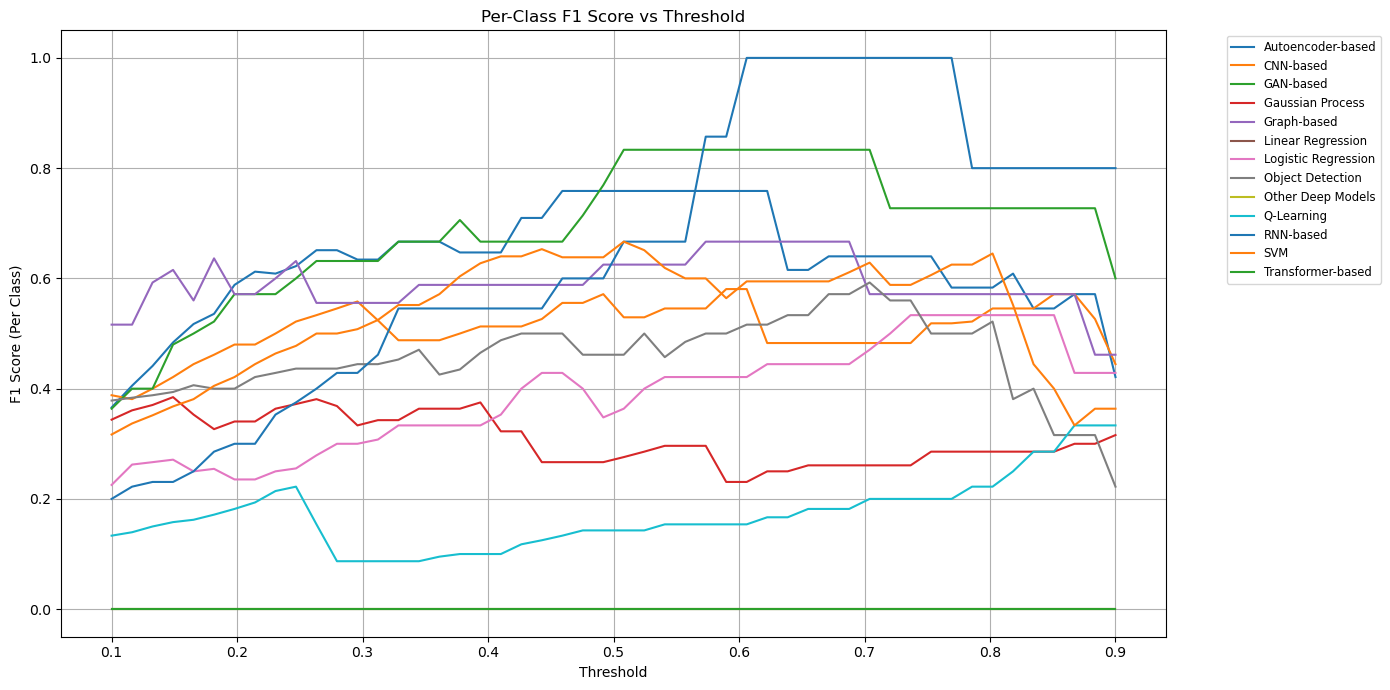

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

thresholds = np.linspace(0.1, 0.9, 50)
num_classes = y_test_filtered.shape[1]
print ("Number of classes:", num_classes)

plt.figure(figsize=(14, 7))
label_names = ['Autoencoder-based', 'CNN-based', 'GAN-based',
               'Gaussian Process', 'Graph-based', 'Linear Regression',
               'Logistic Regression', 'Object Detection', 'Other Deep Models',
               'Q-Learning', 'RNN-based', 'SVM', 'Transformer-based']
for i in range(num_classes-3):
    f1s = []
    for t in thresholds:
        y_pred_class = (y_pred_proba[:, i] >= t).astype(int)
        f1 = f1_score(y_test_filtered[:, i], y_pred_class, zero_division=0)
        f1s.append(f1)
    print (thresholds.shape[0])
    plt.plot(thresholds, f1s, label=label_names[i])

plt.xlabel("Threshold")
plt.ylabel("F1 Score (Per Class)")
plt.title("Per-Class F1 Score vs Threshold")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


IndexError: list index out of range

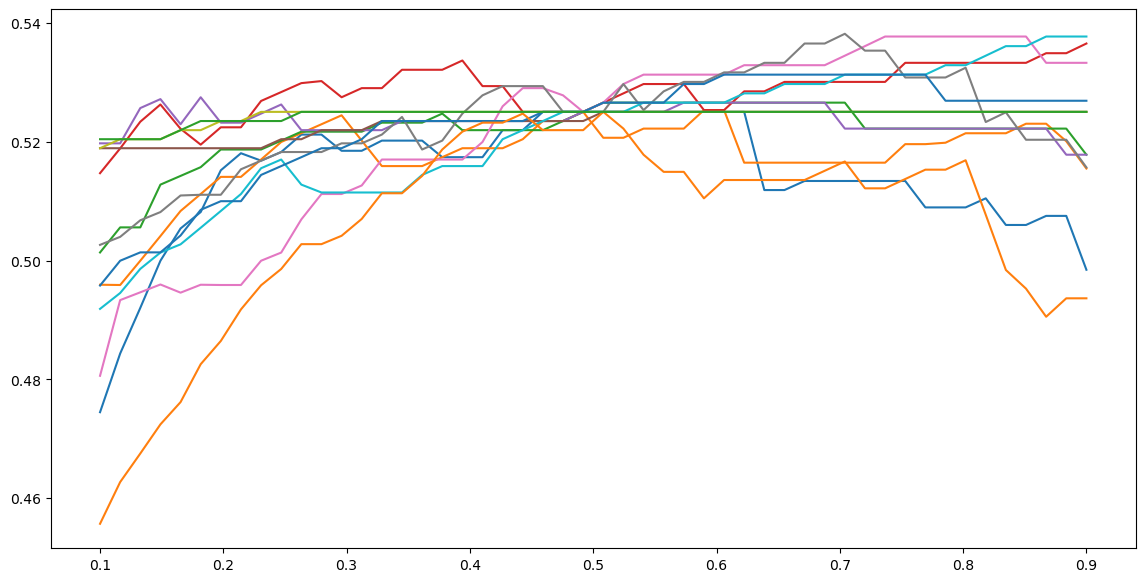

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

thresholds = np.linspace(0.1, 0.9, 50)
num_classes = y_test_filtered.shape[1]
num_classes = 13

label_names = ['Autoencoder-based', 'CNN-based', 'GAN-based',
               'Gaussian Process', 'Graph-based', 'Linear Regression',
               'Logistic Regression', 'Object Detection', 'Other Deep Models',
               'Q-Learning', 'RNN-based', 'SVM', 'Transformer-based']

plt.figure(figsize=(14, 7))

for i in range(num_classes):
    micro_f1s = []
    for t in thresholds:
        # Set all thresholds to 0.5, then just tweak one class
        test_thresholds = np.ones(num_classes) * 0.5
        test_thresholds[i] = t

        y_pred = (y_pred_proba >= test_thresholds).astype(int)
        f1_micro = f1_score(y_test_filtered, y_pred, average='micro', zero_division=0)
        micro_f1s.append(f1_micro)

    plt.plot(thresholds, micro_f1s, label=label_names[i])  # or f"Class {i}"

plt.xlabel("Threshold (per class, others = 0.5)")
plt.ylabel("Global Micro F1")
plt.title("Impact of Per-Class Threshold Tuning on Global Micro F1 - Logistic Regression")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
plt.figure(figsize=(14, 7))

for i in range(num_classes):
    macro_f1s = []
    for t in thresholds:
        test_thresholds = np.ones(num_classes) * 0.5
        test_thresholds[i] = t
        y_pred = (y_pred_proba >= test_thresholds).astype(int)
        f1_macro = f1_score(y_test_filtered, y_pred, average='macro', zero_division=0)
        macro_f1s.append(f1_macro)

    plt.plot(thresholds, macro_f1s, label=label_names[i])  # Or f"Class {i}"

plt.xlabel("Threshold (for class i, others = 0.5)")
plt.ylabel("Global Macro F1")
plt.title("Macro F1 vs Per-Class Threshold - Logistic Regression")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'num_classes' is not defined

<Figure size 1400x700 with 0 Axes>

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 7))

for i in range(y_test_filtered.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_filtered[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title("ROC Curves (Per Class) - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.show()


NameError: name 'plt' is not defined